# Data Mining Final Project Group 6
Chirag Lakhanpal, Amy Sharp, and James Crim

# Setup

In [69]:
# code to widen the coding window (for James, idk if it will affect y'alls setups)
from IPython.core.display import display, HTML;
display(HTML("<style>.container { width:95% !important; }</style>"));

In [70]:
from scipy import stats

In [119]:
# package imports (jimbus)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import wbgapi as wb
import statsmodels.api as sm
import seaborn as seas

# merf
from merf.merf import MERF
from merf.viz import plot_merf_training_stats

# sklearn and subpackages
import sklearn as skl
from sklearn import model_selection as mdl_slct
#from sklearn.linear_model import LassoCV
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import RidgeCV
#from sklearn.model_selection import LeaveOneOut
#from sklearn.model_selection import RepeatedKFold
#from sklearn.decomposition import PCA
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [72]:
# supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [73]:
# common
#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import statsmodels.api as sm

In [74]:
# sklearn
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split, KFold
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error
#from sklearn import linear_model
#from sklearn.linear_model import LinearRegression
#from sklearn import model_selection
#from sklearn.model_selection import RepeatedKFold
#from sklearn.ensemble import RandomForestRegressor
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn import metrics
#from sklearn.preprocessing import StandardScaler

In [75]:
# merf
#from merf import *
##from merf.evaluator import plot_bhat, plot_training_stats
#from merf.merf import MERF

In [76]:
# plotting related imports
import warnings
warnings.filterwarnings('ignore')

In [77]:
# misc imports
#import os, sys
#sys.path.append('..')
#from tabulate import tabulate
#import wbgapi as wb

In [78]:
# plotting settings
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline
#seas.set(style="ticks", context="talk")
#plt.style.use("dark_background")
#seas.set_context("poster")

In [79]:
# set figure sizes
#mpl.rcParams['figure.figsize'] = (11,8)
plt.rcParams['figure.figsize'] = [24, 6]

In [80]:
# set seed (probably unescessary but couldn't hurt)
np.random.seed(2022)

# Import Data

In [81]:
# set up for importing data from API

# get set of country codes to use to import data from world bank
country_names_raw = pd.read_csv('CountrUsedN(1).csv', header=None)
country_names = country_names_raw.iloc[:, 0].to_list()
country_codes_list = list(wb.economy.coder(country_names).values())
country_codes_set = set(country_codes_list)

# years of interest ("since 1994")
year_list = range(1994, 2020)
year_list_strings = np.array(year_list).astype(str)

# the seven indexes to use (copied from WorldBankIndUsed.docx from the Data Mining Blackboard)
# note: CO2 emmissions per captia (CO2 kt / pop) is the outcome variable, the other x variables are predictor variables
world_bank_index_codes = ['EN.ATM.CO2E.KT', 'NY.GDP.MKTP.PP.KD',  'SP.POP.TOTL', 'EG.FEC.RNEW.ZS', 'SP.URB.TOTL.IN.ZS', 'NV.MNF.TECH.ZS.UN', 'NE.TRD.GNFS.ZS']

In [82]:
# import the data from the API
# URL of API package: https://pypi.org/project/wbgapi/
raw_dat = wb.data.DataFrame(world_bank_index_codes, country_codes_set, year_list, labels=True)

# swap around the way the three dimensions are multi-indexed such that country and then year are on the x axis (rows) and economic indicators are on the y axis (columns)
dat = raw_dat.pivot(index='Series', columns='Country').transpose().swaplevel().sort_index()

# remove missing data
dat = dat.dropna()

# detect any missing data, all zeros means no missing data
print('All zeros means no missing data')
print(np.sum(dat.isna()))

# create composite outcome variable
dat['CO2 Emissions (kt) per Capita'] = dat['CO2 emissions (kt)'] / dat['Population, total']

# names manually typed up (same order as indexes):
world_bank_index_names_short = ['CO2 emissions', 'GDP per capita', 'Perc Manufacturing Value Added', 'Total Population',
                                'Renewable energy consumption', 'Trade (% of GDP)', 'Urban Population', 'CO2 emissions per capita']
#world_bank_index_names_short = ['CO2 Emissions (kt)', 'GDP per Capita', '% Med/High Manufacturing', 'Total Population', 
#                                '% Renewable Energy', '% Trade of GDP', '% Urban', 'CO2 Emissions (kt) per Capita']

# renaming columns to shorter names (unused)
dat.columns = world_bank_index_names_short

# add year name to index
dat.index = dat.index.rename(['Country', 'Year'])

# save created data
dat.to_pickle("Data Mining Final Project Starting Data (WB Data).pkl")

# load created data
#dat = pd.read_pickle("Data Mining Final Project Starting Data (WB Data).pkl")

# rename dat to raw_dataset
raw_dataset = dat.copy()

All zeros means no missing data
Series
CO2 emissions (kt)                                                              0
GDP, PPP (constant 2017 international $)                                        0
Medium and high-tech manufacturing value added (% manufacturing value added)    0
Population, total                                                               0
Renewable energy consumption (% of total final energy consumption)              0
Trade (% of GDP)                                                                0
Urban population (% of total population)                                        0
dtype: int64


In [83]:
raw_dataset.columns

Index(['CO2 emissions', 'GDP per capita', 'Perc Manufacturing Value Added',
       'Total Population', 'Renewable energy consumption', 'Trade (% of GDP)',
       'Urban Population', 'CO2 emissions per capita'],
      dtype='object')

## Assorted Useful Functions for Getting Slices of the Data

In [84]:
# function to get a 2D dataframe of all country and measure data from a specific, single year
def get_year_data(year):
    return pd.DataFrame(dat.swaplevel().loc['YR'+str(year)])

# function to get a 2D dataframe of all years and measure data from a specific, single country
def get_country_data(country):
    return dat.loc[country]

# function to get a 1D multiplex dataframe of all years and all countries for a specific, single measure
def get_measure_data(measure_name):
    return pd.DataFrame(dat.loc[:, measure_name])

# function to get 1D multiplex dataframe of country data from a specific range of years for a specific measure
def get_specific_measures_for_specific_years(measure_name, year_start, year_end):
    year_end = year_end+1
    years_of_interest = np.char.add(np.repeat('YR', year_end-year_start), np.array(range(year_start, year_end)).astype(str))
    #print(years_of_interest_names)
    return pd.DataFrame(dat.swaplevel().loc[years_of_interest, measure_name])

# example use of functions
#get_country_data('United States')
#get_year_data(2003)
#get_measure_data('Population, total')
#get_specific_measures_for_specific_years(measure_name='Population, total', year_start=1994, year_end=2008)

# Overview/Descriptive Stats

In [85]:
# create function to get an overview of some base descriptive statistics
def get_data_overview(raw_dataset):
    col = ['Number of variables',
    'Number of observations',
    'Missing cells',
    'Missing cells (%)',
    'Rows with Missing cells',
    'Rows with Missing cells (%)',
    'Duplicate rows',
    'Duplicate rows (%)']

    val = [len(raw_dataset.columns),
    len(raw_dataset),
    raw_dataset.isna().values.sum(),
    (raw_dataset.isna().values.sum()/len(raw_dataset)) * 100,
    len(raw_dataset) - len(raw_dataset.dropna()),
    ((len(raw_dataset)-len(raw_dataset.dropna()))/len(raw_dataset)) * 100,
    raw_dataset.duplicated().sum(),
    raw_dataset.duplicated().sum()]

    val = list(map(round,val))

    return pd.DataFrame(zip(col,val), columns=['Variables', 'Count'])

# use overview function
overview = get_data_overview(raw_dataset)
overview

,Variables,Count
0,Number of variables,8
1,Number of observations,1443
2,Missing cells,0
3,Missing cells (%),0
4,Rows with Missing cells,0
5,Rows with Missing cells (%),0
6,Duplicate rows,0
7,Duplicate rows (%),0


# Side-by-Side Plots

In [86]:
def groupby_by_predictor_plot(ax, groupby_name, predictor_name):
    
    # set outcome variable name
    outcome_name = 'CO2 emissions per capita'
    
    # set labels
    ax.set_title(groupby_name)
    ax.set_xlabel(predictor_name)
    ax.set_ylabel(outcome_name)
    
    # make scatterplot between set predictor and outcome variables for country or year
    dat2plot = dat.groupby(groupby_name).mean()
    x2plot = dat2plot[predictor_name]
    y2plot = dat2plot[outcome_name]
    ax.scatter(x2plot, y2plot)
    
    # get list of text labels
    txt2plot = []
    if groupby_name == 'Country':
        txt2plot = country_names
    elif groupby_name == 'Year':
        txt2plot = year_list_strings
    
    # add text labels
    for i, txt in enumerate(txt2plot):
        ax.annotate(txt, (x2plot[i], y2plot[i]))

In [87]:
def side_by_side_plot(predictor_name):
    
    # create figure and title
    fig, axs = plt.subplots(1, 2);
    fig.suptitle(predictor_name);
    
    # create plots for country and year respectively
    groupby_by_predictor_plot(ax=axs[0], groupby_name='Country', predictor_name=predictor_name)
    groupby_by_predictor_plot(ax=axs[1], groupby_name='Year', predictor_name=predictor_name)

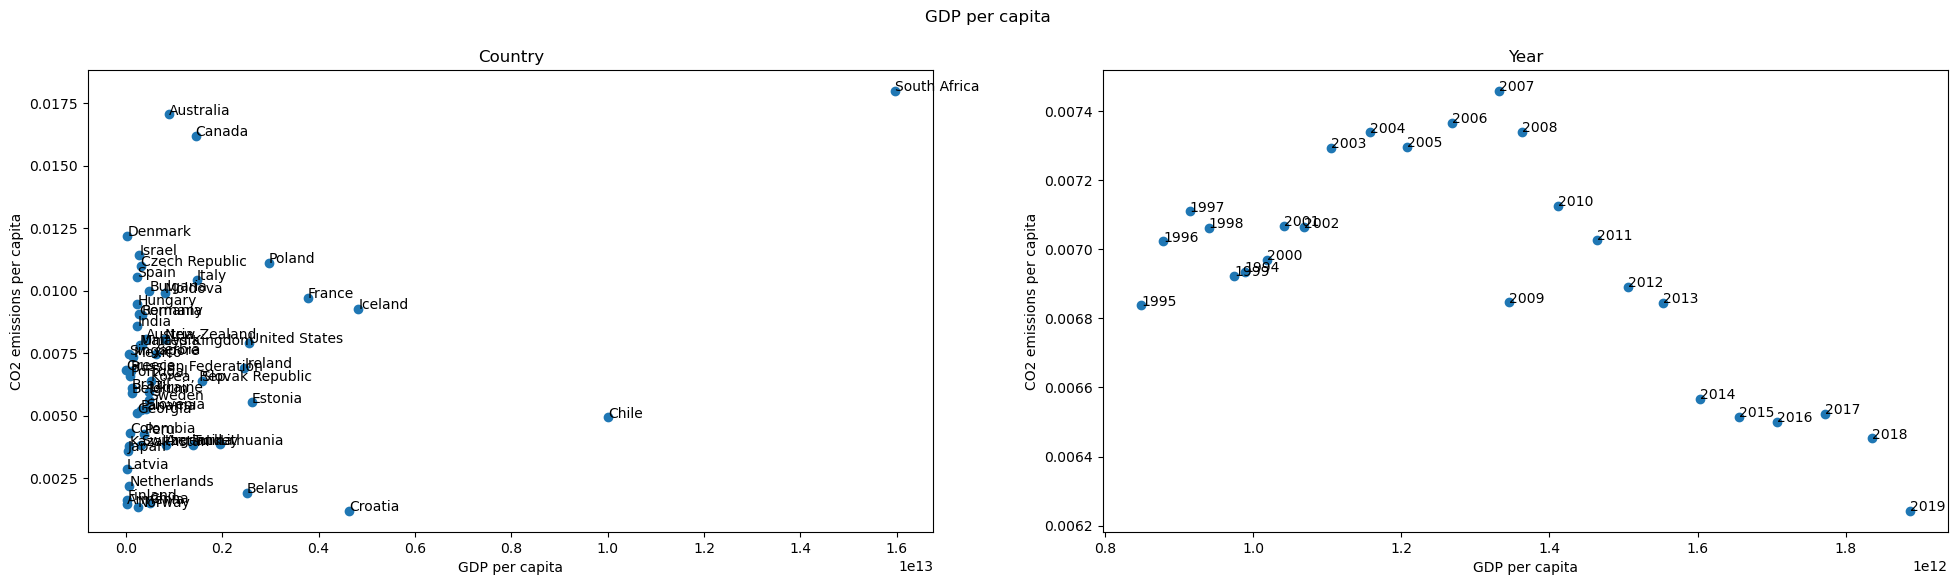

In [88]:
# plot the scatterplot of predicters against the outcome variable averaged across countries and years. Each point is labeled.
# Note that while many of the labels, particularly for countries, are overlapping and difficult to read, the outliers are easy to
# discern which is most important for this step of the project.
side_by_side_plot('GDP per capita')

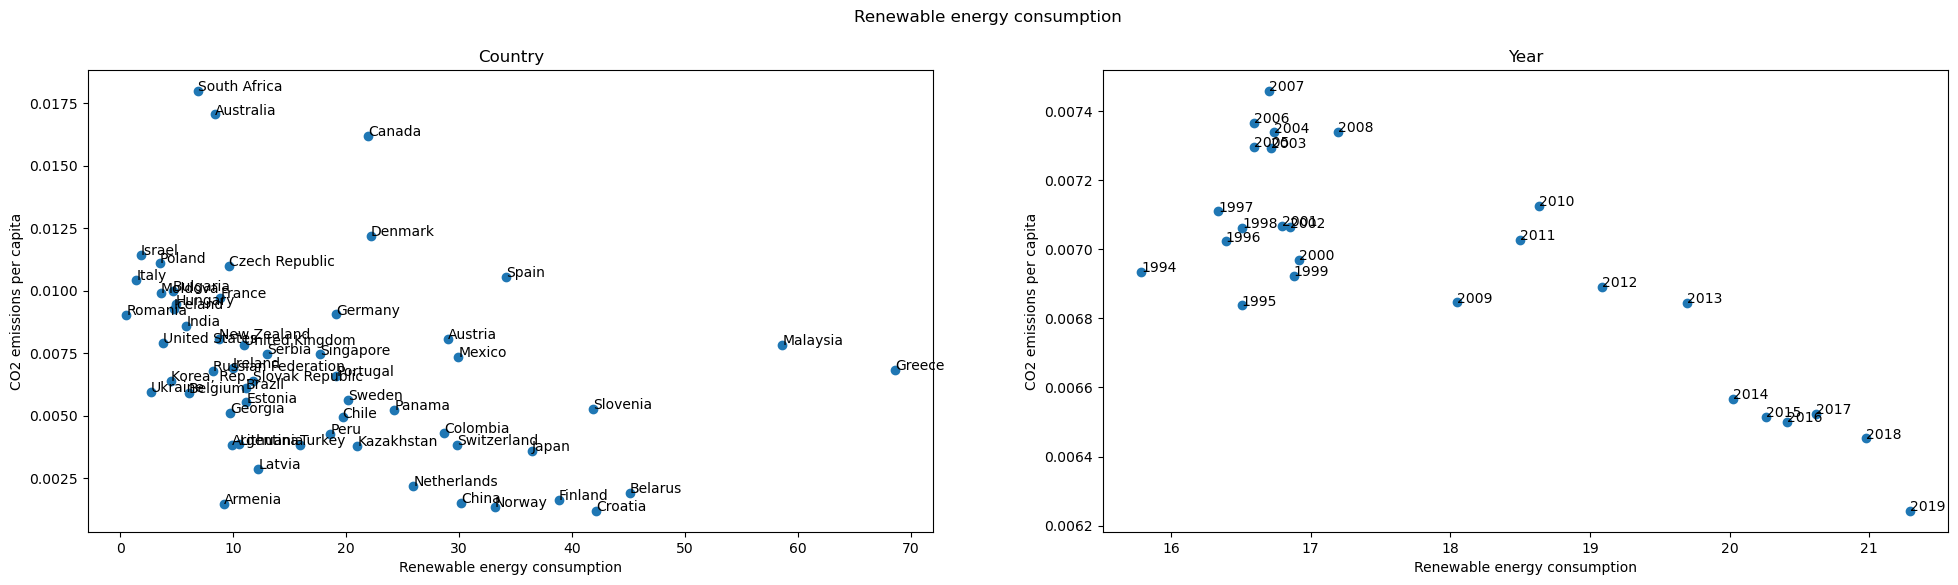

In [89]:
side_by_side_plot('Renewable energy consumption')

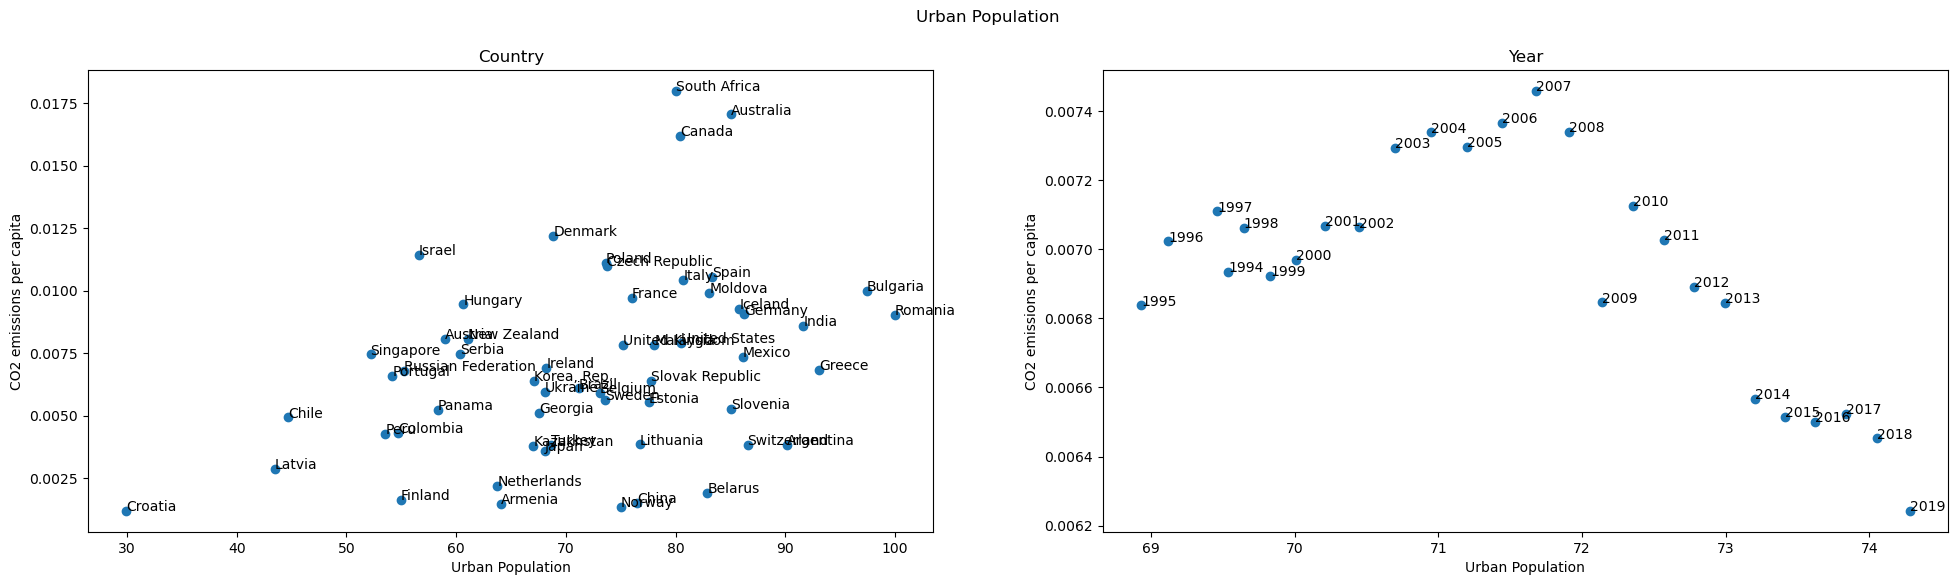

In [90]:
side_by_side_plot('Urban Population')

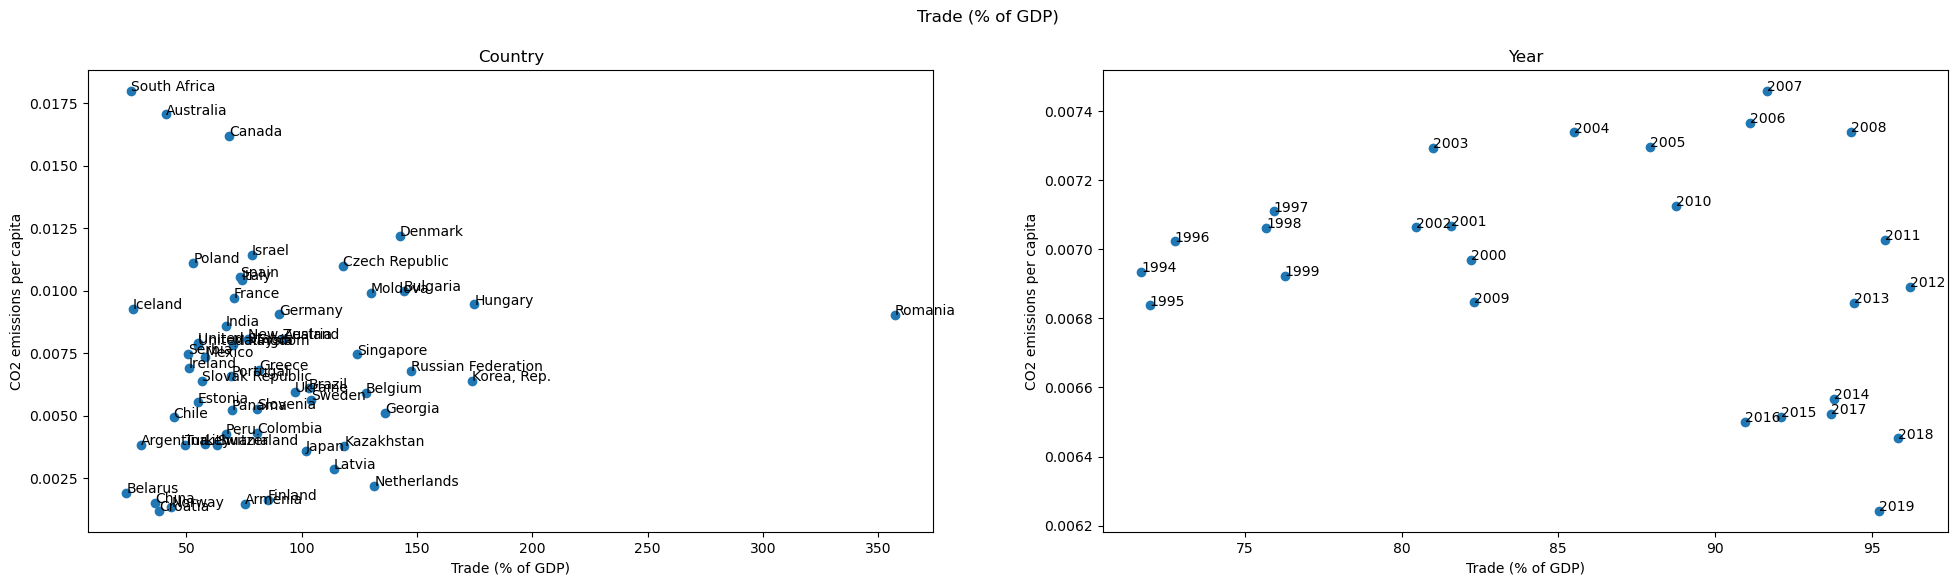

In [91]:
side_by_side_plot('Trade (% of GDP)')

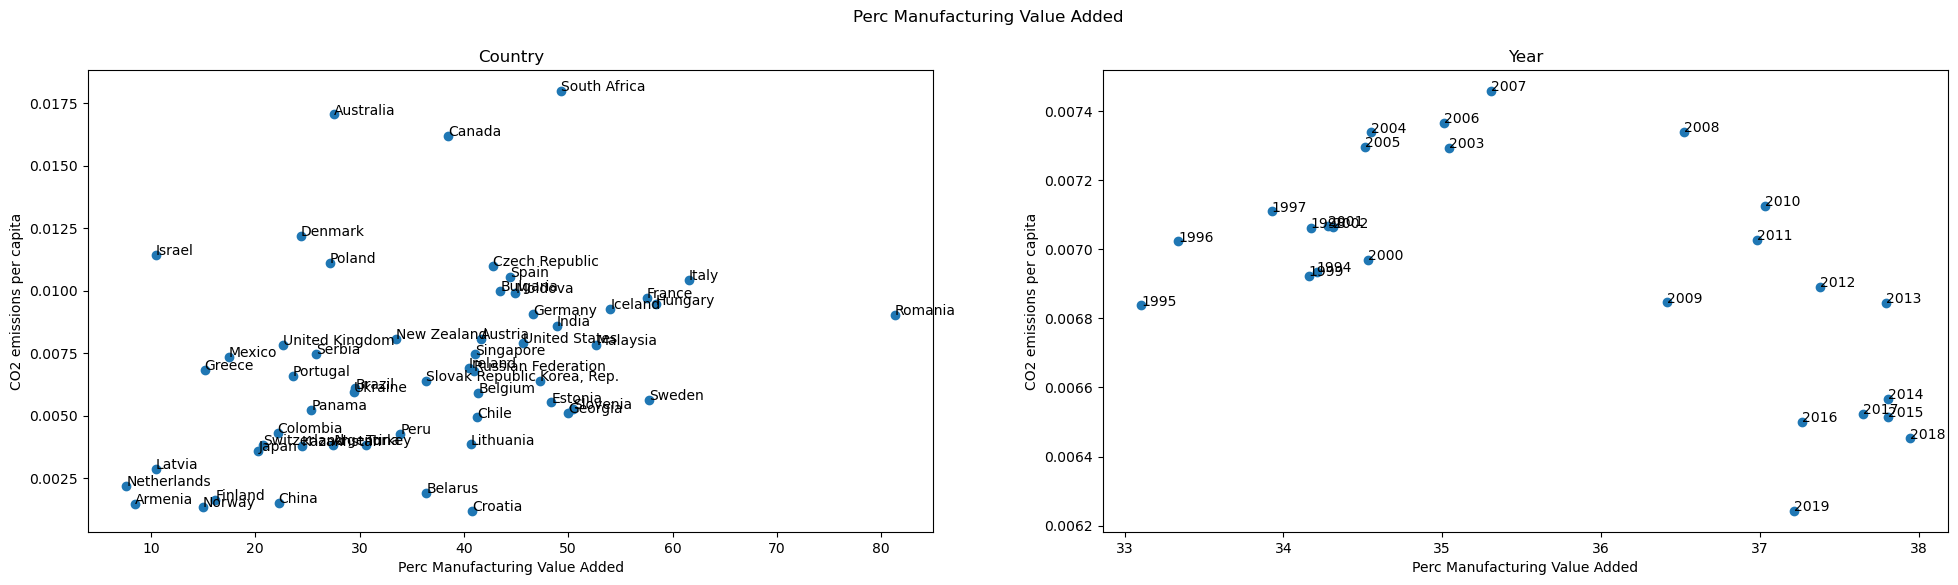

In [92]:
side_by_side_plot('Perc Manufacturing Value Added')

Notes: Overall no year for any measure looks like a particular outlier. However, for countries, Romania, South Africa, and Chile are all glaring outliers in at least one predictor measure, and so these plots would suggest they be removed as outliers.

# Outlier detection and treatment

In [93]:
def outlier_treatment(dataset):
    # outliers more than three sds away are replaced with the mean value of the column
    outlier_summary = []

    for col in dataset.columns[2:]:
        outliers = dataset[(np.abs(stats.zscore(dataset[col]))>3)][col]
        outlier_summary.append([col, len(outliers)])
        dataset.loc[outliers.index, col] = dataset[col].mean()

    outlier_summary = pd.DataFrame(outlier_summary, columns=['Variables', 'No. of Outliers'])

    return dataset, outlier_summary

# run function
raw_dataset_no_outliers = raw_dataset.copy()
raw_dataset_no_outliers, outlier_summary = outlier_treatment(raw_dataset_no_outliers)

outlier_summary

,Variables,No. of Outliers
0,Perc Manufacturing Value Added,10
1,Total Population,52
2,Renewable energy consumption,14
3,Trade (% of GDP),27
4,Urban Population,10
5,CO2 emissions per capita,15


# Log Trasforming the data

In [94]:
# log base 10 transform the data
processed_df = raw_dataset_no_outliers.copy()
for col in [col for col in processed_df.columns[0:]]:
    processed_df[col] = np.log10(processed_df[col] + 1)

# Data Summary (Post-Outlier Removal and Log Transformation)

In [95]:
# describe the cleaned data
processed_df.describe(include='all')

,CO2 emissions,GDP per capita,Perc Manufacturing Value Added,Total Population,Renewable energy consumption,Trade (% of GDP),Urban Population,CO2 emissions per capita
count,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,4.984459,11.600147,1.509789,7.179238,1.115691,1.863056,1.853878,0.002947
std,0.734537,0.686705,0.231886,0.607142,0.391837,0.218728,0.090003,0.001561
min,3.212454,9.954466,0.690589,5.427273,0.123852,1.158007,1.475715,0.000315
25%,4.583097,11.180345,1.405031,6.721371,0.867761,1.733932,1.797787,0.001768
50%,4.843239,11.572287,1.569113,7.035915,1.148911,1.866179,1.872180,0.002858
75%,5.525500,12.087101,1.674872,7.675878,1.445530,2.014420,1.916499,0.003854
max,7.029677,13.352040,1.924619,8.516311,1.802568,2.358700,2.004321,0.007877


# Distrobution Plots

In [96]:
# plotting settings
%load_ext autoreload
%autoreload 2
%matplotlib inline
seas.set(style="ticks", context="talk")
plt.style.use("dark_background")
#seas.set_context("poster")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


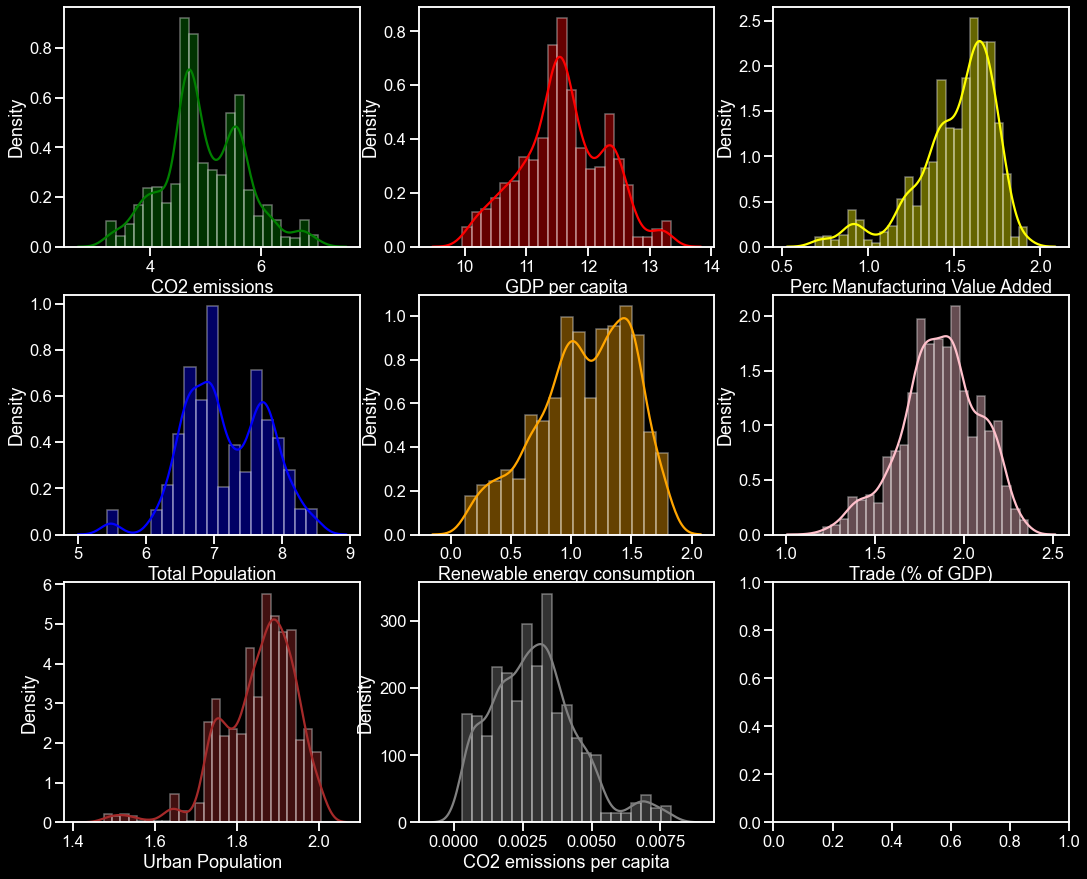

In [97]:
# plot
n_rows=3
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (18,15))

colors = {0:'green',1:'red',2:'yellow',3:'blue',4:'orange',5:'pink',6:'brown',7:'gray'}

for i, column in enumerate(processed_df.columns[0:8]):
     seas.distplot(processed_df[column],color= colors[i],ax=axes[i//n_cols,i%n_cols]);

# Pair Plots

In [98]:
# add country and year duplicate columns for easy graphing
processed_df['Country_col'] = processed_df.index.to_frame()['Country'].values
processed_df['Year_col'] = processed_df.index.to_frame()['Year'].values

In [99]:
#seas.pairplot(data=processed_df.drop(labels=['CO2 emissions', 'Total Population'], axis=1, inplace=False), hue='Country_col', palette="Set1");

In [100]:
#seas.pairplot(data=processed_df,  hue='Year_col', palette="Set1");

# Modeling Work

## Split Data Into Testing/Training Groups

In [101]:
# split data into testing/training with 80% training
predictor_var_name = 'CO2 emissions'
training_percentage = 0.8

xz_train, xz_test, y_train, y_test = mdl_slct.train_test_split(
                                          processed_df.drop(predictor_var_name, axis=1),
                                          processed_df[predictor_var_name], train_size=training_percentage, random_state=2022, shuffle=True)

# make combined test and training datasets
train = xz_train.copy()
train[predictor_var_name] = y_train
test = xz_test.copy()
test[predictor_var_name] = y_test

# make predictor only test and training datasets
x_train = xz_train.copy()
x_train = x_train.drop(['Country_col', 'Year_col'], axis=1)
x_test = xz_test.copy()
x_test = x_test.drop(['Country_col', 'Year_col'], axis=1)

# pull out cluster variables (random effects, ie country and year)
cluster_train = train[['Country_col', 'Year_col']]
cluster_test = test[['Country_col', 'Year_col']]

In [102]:
plt.style.use("default")

## Notes from Professor

In [103]:
## NOTES FROM MEETING WITH PROF

# can run forrest on residuals if want country to be fixed (see past homeworks)

# treat countries as random effects to generalize beyond the given set of countries (philosophically)
# econmetric argument: random effects should be uncorrelated with covariates (can test this)

# many important, unmeasured variables that are captured in the "error" of our model
# random effect countries can "suck up" this error, which isn't good
# tests for use of mixed effects models, by looking at residuals of models
# assume countries are randomly selected

# year has order, is more structured, not randomly selected
# time as random

# use sme for model output

# have x be world bank columns

# z is 2D array of ones, we can do this

# cluster is countries??

# vary the model complexity parameters (such as # leaves, branches, etc., see documentation), kinda just trial and error
# try to keep individual trees not too complex (all relative)
# number of splits may be total number of splits
# go until things level off or minimize

# measures to compare different models: cross validation, 
    # repeated cross-validation is best comprimise, doing it two or three times

## Modeling

In [104]:
# make z a list of ones
z_temp_train = pd.DataFrame(np.ones(len(y_train)))
z_temp_test = pd.DataFrame(np.ones(len(y_test)))

In [105]:
# combine the world bank predictors with the years column, drop the total pop column to be ready for modeling
x2model_train = pd.concat([x_train, cluster_train['Year_col']], axis=1).drop(['Total Population'], axis=1)
x2model_test = pd.concat([x_test, cluster_test['Year_col']], axis=1).drop(['Total Population'], axis=1)

# change the years from string to int
x2model_train['Year_col'] = x2model_train['Year_col'].str.split(pat='R', n=1, expand=True).iloc[:, 1].astype(int)
x2model_test['Year_col'] = x2model_test['Year_col'].str.split(pat='R', n=1, expand=True).iloc[:, 1].astype(int)

In [106]:
# testing using z as all ones (called "z_temp")
cluster_col = 'Country_col'
merf = MERF()
merf.fit(x2model_train, z_temp_train, cluster_train[cluster_col], y_train);
y_hat_train = merf.predict(x2model_train, z_temp_train, cluster_train[cluster_col]);
y_hat_test = merf.predict(x2model_test, z_temp_test, cluster_test[cluster_col]);

In [107]:
train_mse = np.mean(np.square(y_hat_train - y_train))
print(train_mse)
test_mse = np.mean(np.square(y_hat_test - y_test))
print(test_mse)

0.00014798673049264743
0.0010081552853612237


In [108]:
y_std = processed_df['CO2 emissions per capita'].describe()[2]
print(y_std)

0.001560727208036328


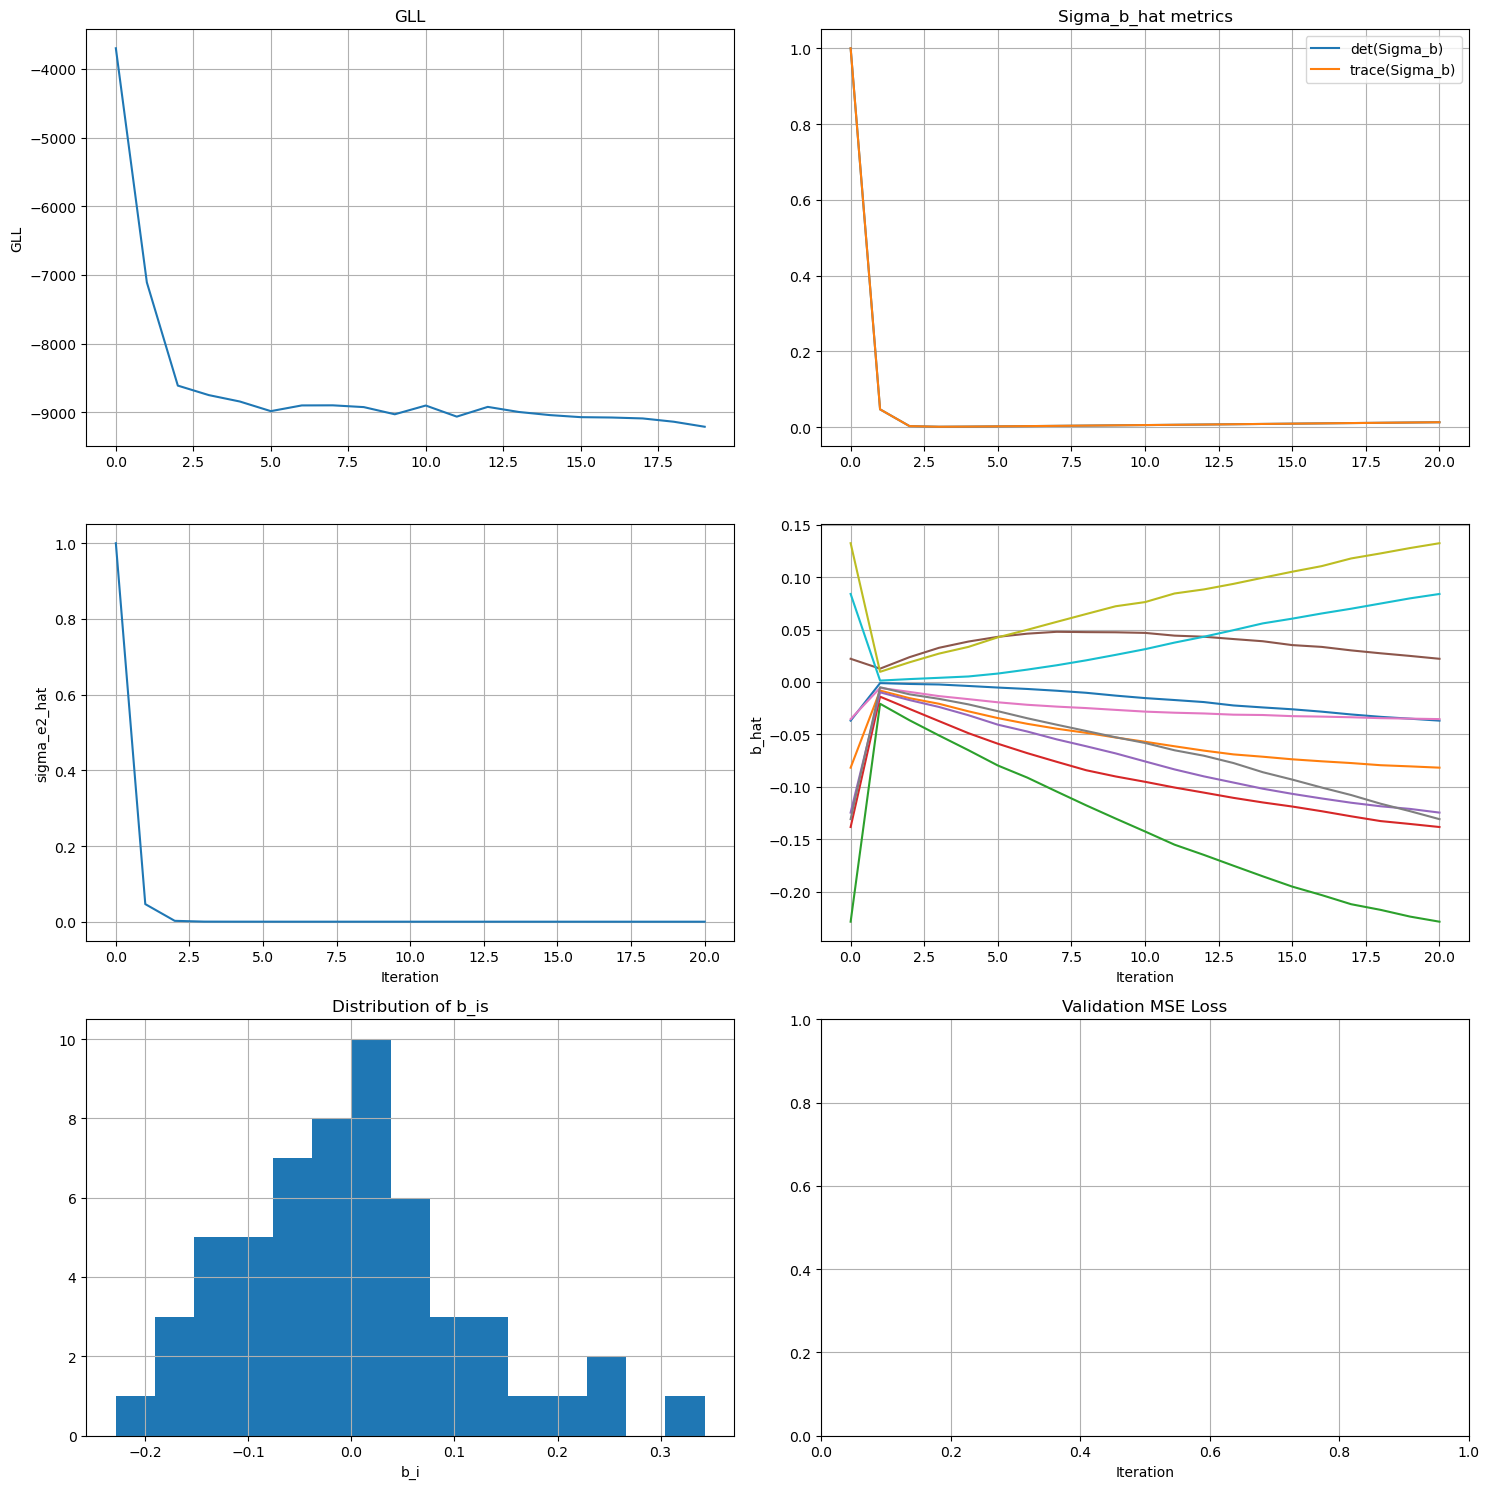

In [109]:
plot_merf_training_stats(merf, num_clusters_to_plot=10)

# Split and Modeling Function For Trying Different Parameters

In [126]:
# function to split and model data
def split_model(processed_df, max_depth=None, max_features='auto', max_leaf_nodes=None, n_trees=300, max_iterations=20):

    # split data into testing/training with 80% training
    predictor_var_name = 'CO2 emissions per capita'
    training_percentage = 0.8

    # remove total population and co2 emissions (unused for modeling)
    dat2model = processed_df.copy()
    dat2model.drop(['CO2 emissions', 'Total Population'], axis=1, inplace=True)

    # split the data
    x_train, x_test, y_train, y_test = mdl_slct.train_test_split(
                                              dat2model.drop(predictor_var_name, axis=1),
                                              dat2model[predictor_var_name], 
                                              train_size=training_percentage, shuffle=True)

    # make combined test and training datasets
    train = x_train.copy()
    train[predictor_var_name] = y_train
    test = x_test.copy()
    test[predictor_var_name] = y_test

    # pull out cluster variables (random effects, ie country and year)
    cluster_train = train['Country_col']
    cluster_test = test['Country_col']

    # remove country columns from x_ dataframes
    x_train.drop('Country_col', axis=1, inplace=True)
    x_test.drop('Country_col', axis=1, inplace=True)

    # make z a list of ones
    z_temp_train = pd.DataFrame(np.ones(len(y_train)))
    z_temp_test = pd.DataFrame(np.ones(len(y_test)))

    # change the years from string to int
    x_train['Year_col'] = x_train['Year_col'].str.split(pat='R', n=1, expand=True).iloc[:, 1].astype(int)
    x_test['Year_col'] = x_test['Year_col'].str.split(pat='R', n=1, expand=True).iloc[:, 1].astype(int)

    # set the model parameters
    #max_depth = 1
    #max_features = 1
    #max_leaf_nodes = 1
    #n_trees = 1
    #max_iterations = 1
    merf = MERF(fixed_effects_model=RandomForestRegressor(
                    max_depth=max_depth, 
                    max_features=max_features, 
                    max_leaf_nodes=max_leaf_nodes, 
                    n_estimators=n_trees), 
                    max_iterations=max_iterations)
    
    # run the model
    merf.fit(x_train, z_temp_train, cluster_train, y_train);
    #y_hat_train = merf.predict(x_train, z_temp_train, cluster_train);
    y_hat_test = merf.predict(x_test, z_temp_test, cluster_test);

    # get MSE
    #train_mse = np.mean(np.square(y_hat_train - y_train))
    #print(train_mse)
    test_mse = np.mean(np.square(y_hat_test - y_test))
    print('Test MSE: '+str(test_mse))

    # get dataset variance
    #y_std = processed_df['CO2 emissions per capita'].describe()[2]
    #print(y_std)
    
    # return MSE
    #return test_mse

In [131]:
# default parameters
split_model(processed_df, max_depth=None, max_features='auto', max_leaf_nodes=None, n_trees=300, max_iterations=20)

Test MSE: 9.180423982814117e-08


In [132]:
# try different parameters
split_model(processed_df, max_depth=10)

Test MSE: 9.638414363163313e-08


In [133]:
split_model(processed_df, max_depth=100)

Test MSE: 8.336089725154094e-08


In [134]:
split_model(processed_df, max_depth=1000)

Test MSE: 4.1576906069072406e-08


In [136]:
#split_model(processed_df, max_features=10)

In [ ]:
#split_model(processed_df, max_features=100)

In [ ]:
#split_model(processed_df, max_features=1000)

In [137]:
split_model(processed_df, max_leaf_nodes=10)

Test MSE: 1.8821755143817473e-07


In [138]:
split_model(processed_df, max_leaf_nodes=100)

Test MSE: 6.597405007993074e-08


In [139]:
split_model(processed_df, max_leaf_nodes=1000)

Test MSE: 3.324352541744811e-08


In [147]:
split_model(processed_df, n_trees=30)

Test MSE: 6.325662350998578e-08


In [148]:
split_model(processed_df, n_trees=300)

Test MSE: 1.1822023003592751e-07


In [149]:
split_model(processed_df, n_trees=3000)

Test MSE: 1.2137873778235633e-07


In [143]:
split_model(processed_df, max_iterations=2)

Test MSE: 1.1586147275735883e-07


In [144]:
split_model(processed_df, max_iterations=20)

Test MSE: 1.0036412906720851e-07


In [145]:
split_model(processed_df, max_iterations=200)

Test MSE: 3.660545749204113e-08


In [146]:
    # get dataset variance
    y_std = processed_df['CO2 emissions per capita'].describe()[2]
    print(y_std)

0.001560727208036328


# End